[Text(0.5, 0, 'Redshift'), Text(0, 0.5, 'Counts')]

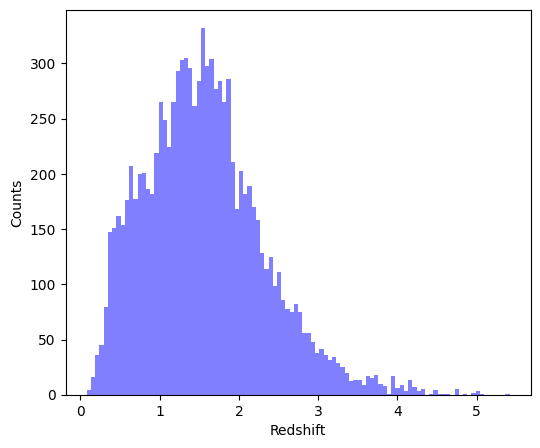

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import fetch_dr7_quasar
from scipy.stats import rv_histogram

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

Nbins=100
fig,ax=plt.subplots(1,1,figsize=(6,5))

x = np.linspace(min(z), max(z), Nbins)
hist = np.histogram(z, bins=Nbins)
distr = rv_histogram(hist, density=True)
ax.hist(z, bins=Nbins, color = 'blue', alpha = 0.5, label = 'True distribution')
ax.set(xlabel='Redshift',ylabel='Counts')

Only 16.89% of the points are generated correctly


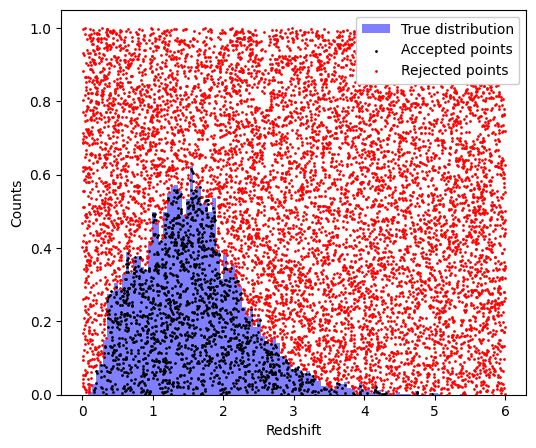

In [2]:
# trying to sample from the distribution with rejection sampling

x = np.random.uniform(int(min(x)),int(max(x))+1,len(z))
y = np.random.uniform(int(min(distr.pdf(x))),int(max(distr.pdf(x)))+1,len(z))
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.hist(z, bins=Nbins, color = 'blue', alpha = 0.5, label = 'True distribution', density=True)
ax.scatter(x[y<distr.pdf(x)],y[y<distr.pdf(x)],c='black',s=1,label='Accepted points')
ax.scatter(x[y>distr.pdf(x)],y[y>distr.pdf(x)],c='red',s=1,label='Rejected points')
ax.set(xlabel='Redshift',ylabel='Counts')
ax.legend(framealpha=1)
x_rej_sample=x[y<distr.pdf(x)]
print(f'Only {len(x_rej_sample)/len(x)*100:.2f}% of the points are generated correctly')

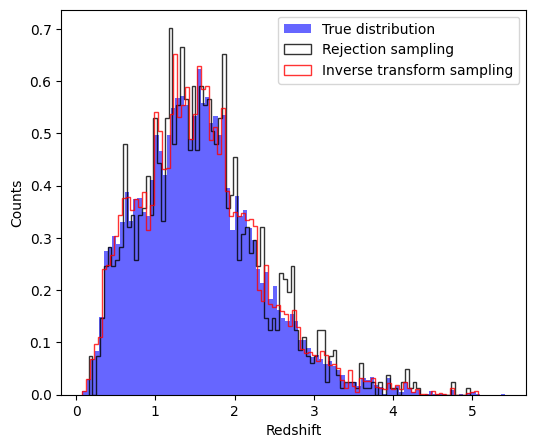

In [3]:
# trying to sample from the distribution with inverse transform sampling
u=np.random.uniform(0, 1, len(z))
x_inv_sample = distr.ppf(u)
# plotting how the data sampled with the two methods behave compared to the original distribution
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.hist(z, bins=Nbins, color = 'blue', alpha = 0.6, histtype = 'stepfilled', label = 'True distribution',density=True)
ax.hist(x_rej_sample, bins=Nbins, color = 'black', alpha = 0.8, histtype='step', label = 'Rejection sampling',density=True)
ax.hist(x_inv_sample, bins=Nbins, color = 'red', alpha = 0.8, histtype='step', label = 'Inverse transform sampling',density=True)
ax.set(xlabel='Redshift',ylabel='Counts')
ax.legend()

In [ ]:
from scipy import stats, interpolate
import scipy
import astropy

# defining a class which compute the Planck18 model with the correct normalization,
# obtained by dividing for the maximum and then by multiplying for an arbitrary unit
# to match the histogram normalization

class uniformredshift(object):
    def __init__(self,zmax):
        ''' Lazy loading...'''
        self._norm = None
        self._pdfmax = None
        self.zmax=zmax

    def _eval(self,z_vals):
        '''Unnormalized pdf'''
        return ((4.*np.pi*astropy.cosmology.Planck18.differential_comoving_volume(z_vals).value))


    def norm(self):
        '''Compute normalization'''
        if self._norm is None:
            self._norm = scipy.integrate.quad( self._eval, 0, self.zmax)[0]
        return self._norm


    def eval(self, z_vals):
        return 2.5*self._eval(z_vals)/self.norm()

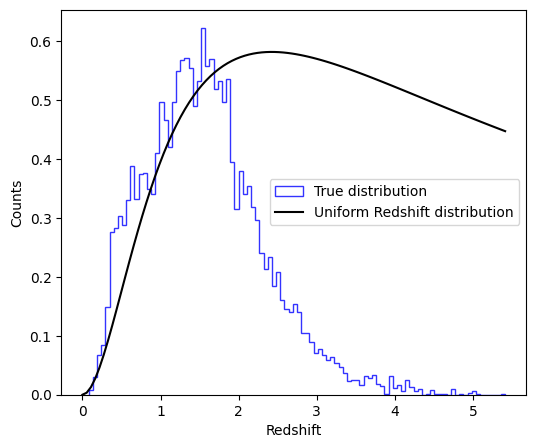

In [5]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
redshiftPDF=uniformredshift(zmax=max(z))
w = np.linspace(0, max(z), 100)
ax.hist(z, bins=Nbins, color = 'blue', alpha = 0.8, histtype = 'step', label = 'True distribution',density=True)
ax.plot(w,redshiftPDF.eval(w),color='black',label='Uniform Redshift distribution')
ax.set(xlabel='Redshift',ylabel='Counts')
ax.legend()